<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/covid19_(18_10_22).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Uploading The Dataset

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d latifuljoy/covid-chest-xray-image-dataset

 99% 481M/484M [00:18<00:00, 23.4MB/s]
100% 484M/484M [00:18<00:00, 26.9MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-chest-xray-image-dataset.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png 

In [6]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 536 images in '/content/COVID_IEEE/normal'.
there are 0 directories and 536 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.


In [7]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

# Data Preprocessing

In [8]:
img_height =224
img_width =224

In [76]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size =32
)

Found 1493 files belonging to 3 classes.
Using 1195 files for training.


In [77]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 1493 files belonging to 3 classes.
Using 298 files for validation.


# Normalization

In [78]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [79]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 0.9996169


In [80]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Developed CNN Model

In [100]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [101]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))


#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

Dropout(0.40)


# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units= 256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.40)

model.add(Dense(units=3, activation="softmax"))

In [102]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [103]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
38/38 [==============================] - 7s 156ms/step - loss: 1.0785 - accuracy: 0.5331 - val_loss: 0.6124 - val_accuracy: 0.7282
Epoch 2/20
38/38 [==============================] - 5s 121ms/step - loss: 0.5144 - accuracy: 0.8285 - val_loss: 0.4200 - val_accuracy: 0.8456
Epoch 3/20
38/38 [==============================] - 5s 122ms/step - loss: 0.3623 - accuracy: 0.8661 - val_loss: 0.5315 - val_accuracy: 0.7785
Epoch 4/20
38/38 [==============================] - 5s 123ms/step - loss: 0.2715 - accuracy: 0.9163 - val_loss: 0.2898 - val_accuracy: 0.9128
Epoch 5/20
38/38 [==============================] - 5s 124ms/step - loss: 0.2706 - accuracy: 0.9021 - val_loss: 0.2407 - val_accuracy: 0.9262
Epoch 6/20
38/38 [==============================] - 5s 125ms/step - loss: 0.1425 - accuracy: 0.9573 - val_loss: 0.2187 - val_accuracy: 0.9195
Epoch 7/20
38/38 [==============================] - 5s 125ms/step - loss: 0.1446 - accuracy: 0.9464 - val_loss: 0.5600 - val_accuracy: 0.7852
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

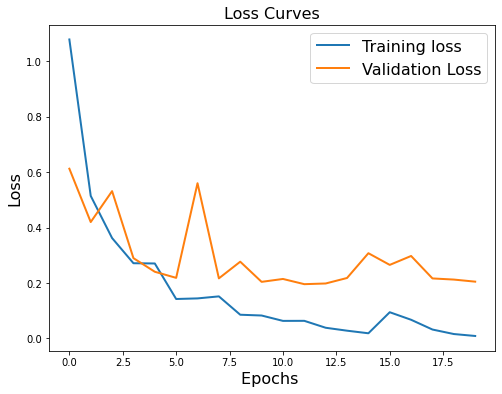

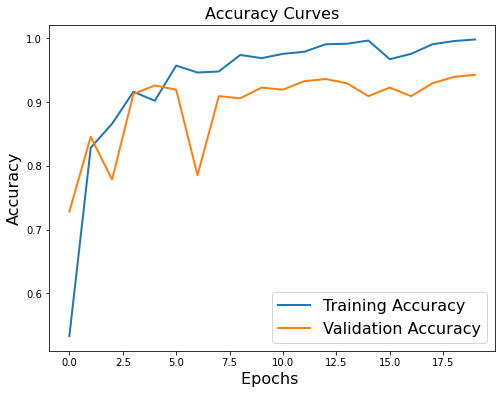

In [104]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],linewidth=2.0)
plt.plot(history1.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],linewidth=2.0)
plt.plot(history1.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
model.save("/content/drive/MyDrive/model.hdf5")

# Transfer Learning Model Inception V3

In [109]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [110]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = InceptionV3(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model1 = Model(inputs = base_model.inputs, outputs = predictions)

In [111]:
model1.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [112]:
history2 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
38/38 [==============================] - 22s 341ms/step - loss: 0.4834 - accuracy: 0.7992 - val_loss: 1.1982 - val_accuracy: 0.4497
Epoch 2/20
38/38 [==============================] - 9s 236ms/step - loss: 0.1138 - accuracy: 0.9674 - val_loss: 1.0453 - val_accuracy: 0.6611
Epoch 3/20
38/38 [==============================] - 9s 239ms/step - loss: 0.0382 - accuracy: 0.9891 - val_loss: 0.7924 - val_accuracy: 0.7919
Epoch 4/20
38/38 [==============================] - 9s 242ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.4837 - val_accuracy: 0.8826
Epoch 5/20
38/38 [==============================] - 9s 242ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.2916 - val_accuracy: 0.9329
Epoch 6/20
38/38 [==============================] - 9s 237ms/step - loss: 8.1411e-04 - accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9497
Epoch 7/20
38/38 [==============================] - 9s 235ms/step - loss: 5.6597e-04 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.95

In [113]:
model1.save("/content/drive/MyDrive/model1.hdf5")

# DenseNet121

In [114]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [115]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = DenseNet121(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model2 = Model(inputs = base_model.inputs, outputs = predictions)

In [117]:
model2.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [118]:
history3 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
38/38 [==============================] - 35s 512ms/step - loss: 0.3790 - accuracy: 0.8477 - val_loss: 0.7034 - val_accuracy: 0.7248
Epoch 2/20
38/38 [==============================] - 14s 364ms/step - loss: 0.0629 - accuracy: 0.9774 - val_loss: 0.6107 - val_accuracy: 0.7617
Epoch 3/20
38/38 [==============================] - 14s 367ms/step - loss: 0.0168 - accuracy: 0.9983 - val_loss: 0.3375 - val_accuracy: 0.8658
Epoch 4/20
38/38 [==============================] - 14s 361ms/step - loss: 0.0084 - accuracy: 0.9992 - val_loss: 0.2092 - val_accuracy: 0.9262
Epoch 5/20
38/38 [==============================] - 14s 359ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.1580 - val_accuracy: 0.9497
Epoch 6/20
38/38 [==============================] - 14s 363ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.1361 - val_accuracy: 0.9396
Epoch 7/20
38/38 [==============================] - 14s 364ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1444 - val_accuracy: 0.9597

In [119]:
model2.save("/content/drive/MyDrive/model2.hdf5")

# MobileNet

In [120]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [121]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = MobileNet(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model3 = Model(inputs = base_model.inputs, outputs = predictions)

In [122]:
model3.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [123]:
history4 = model3.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
38/38 [==============================] - 9s 161ms/step - loss: 0.4656 - accuracy: 0.8117 - val_loss: 3.5279 - val_accuracy: 0.5168
Epoch 2/20
38/38 [==============================] - 5s 133ms/step - loss: 0.0806 - accuracy: 0.9749 - val_loss: 3.4485 - val_accuracy: 0.4497
Epoch 3/20
38/38 [==============================] - 5s 135ms/step - loss: 0.0254 - accuracy: 0.9983 - val_loss: 3.1339 - val_accuracy: 0.5570
Epoch 4/20
38/38 [==============================] - 5s 135ms/step - loss: 0.0120 - accuracy: 0.9992 - val_loss: 3.1718 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 5s 136ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 2.3829 - val_accuracy: 0.5537
Epoch 6/20
38/38 [==============================] - 5s 137ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.1282 - val_accuracy: 0.6443
Epoch 7/20
38/38 [==============================] - 5s 136ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.5233 - val_accuracy: 0.7953
Epoch 

In [125]:
model3.save("/content/drive/MyDrive/model3.hdf5")

# Ensemble Learning Model 1 (Developed CNN+ Inception V3 + DenseNet121)

In [126]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [127]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model("/content/drive/MyDrive/model.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/model1.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [131]:
ensemble_model.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [129]:
history = ensemble_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =15
)

Epoch 1/15
38/38 [==============================] - 53s 805ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.1068 - val_accuracy: 0.9564
Epoch 2/15
38/38 [==============================] - 27s 701ms/step - loss: 0.0276 - accuracy: 0.9975 - val_loss: 0.2380 - val_accuracy: 0.9329
Epoch 3/15
38/38 [==============================] - 26s 689ms/step - loss: 0.0370 - accuracy: 0.9967 - val_loss: 0.1337 - val_accuracy: 0.9597
Epoch 4/15
38/38 [==============================] - 27s 705ms/step - loss: 0.0205 - accuracy: 0.9958 - val_loss: 0.1643 - val_accuracy: 0.9664
Epoch 5/15
38/38 [==============================] - 26s 688ms/step - loss: 0.0279 - accuracy: 0.9958 - val_loss: 0.1772 - val_accuracy: 0.9631
Epoch 6/15
38/38 [==============================] - 27s 707ms/step - loss: 0.0201 - accuracy: 0.9967 - val_loss: 0.1737 - val_accuracy: 0.9631
Epoch 7/15
38/38 [==============================] - 26s 694ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.1246 - val_accuracy: 0.9564

# Ensemble Learning Model 2( Developed CNN+ DenseNEt121+ MobileNet)

In [146]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [147]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model("/content/drive/MyDrive/model.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')


model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

model_4 = load_model('/content/drive/MyDrive/model3.hdf5')
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='name_of_model_4')

models = [model_1, model_3, model_4]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model2 = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [148]:
ensemble_model2.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [149]:
history2 = ensemble_model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =15
)

Epoch 1/15
38/38 [==============================] - 40s 650ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.2268 - val_accuracy: 0.9597
Epoch 2/15
38/38 [==============================] - 23s 599ms/step - loss: 0.0204 - accuracy: 0.9983 - val_loss: 0.0809 - val_accuracy: 0.9631
Epoch 3/15
38/38 [==============================] - 22s 588ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 0.1523 - val_accuracy: 0.9631
Epoch 4/15
38/38 [==============================] - 22s 582ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0978 - val_accuracy: 0.9664
Epoch 5/15
38/38 [==============================] - 22s 582ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.1852 - val_accuracy: 0.9631
Epoch 6/15
38/38 [==============================] - 23s 600ms/step - loss: 0.0080 - accuracy: 0.9983 - val_loss: 0.1047 - val_accuracy: 0.9732
Epoch 7/15
38/38 [==============================] - 22s 582ms/step - loss: 0.0120 - accuracy: 0.9983 - val_loss: 0.0889 - val_accuracy: 0.9664